In [174]:
import time
from math import cos, pi, exp
import numpy
from numba import njit
import matplotlib.pyplot as plt

#Реализация алгоритма ETFSS на Python с использованием Numba

In [175]:
y = 5
n_args_count = 1  # количество x-ов, подаваемых в тестовую функцию
iter_max = 500  # больше 500 не нужно
number_of_agents = 50  # количество агентов популяции (20-40-50 должно быть)
max_weight = 50  # максимальный вес рыбы

##Тестовая функция Растригина
![picture_of_Rastrigen](src/растригина.png)

In [176]:
@njit()
def f(x):  # Тестовая функция Растригина
    A = 10
    result = 0
    for i in x:
        result += i ** 2 - A * cos(2 * pi * i)
    result += A * len(x)

    return result


##Генерация начальных агентов

In [177]:
@njit()
def generate_agents():
    result = numpy.zeros((number_of_agents, n_args_count))
    for i in range(number_of_agents):
        result[i] = numpy.random.uniform(-5.12, 5.12, n_args_count)
    return result


##Реализация алгоритма

In [178]:
@njit()
def main_function():
    step_ind = list()
    step_vol = list()
    p_qbest_list = list()  # массив p_qbest в разные моменты поколений
    # step_ind.append(float(input("Введите макс размер шага индивидуального перемещения: ")))
    # step_vol.append(float(input("Введите макс размер шага коллективно-волевого перемещения: ")))
    step_ind.append(0.05)
    step_vol.append(0.05)
    w = list()
    w.append(numpy.zeros(number_of_agents) + max_weight / 2)

    t = 0  # текущий номер поколения
    P = list()  # Начальная популяция
    P.append(generate_agents())  # Случано сгенерированное текущее поколение
    p_qbest = P[t][0]
    for i in P[t]:
        if f(p_qbest) > f(i):
            p_qbest = i
    p_qbest_list.append(p_qbest)

    f_t = list()
    f_min = f(P[t][0])
    f_t.append(f_min)
    for i in range(1, number_of_agents):
        f_I = f(P[t][i])
        if f_I < f_min:
            f_min = f_I
            p_qbest = P[t][i]
        f_t.append(f_I)

    # значение функции для каждого агента
    F = [numpy.array(f_t)]
    # макс кол-во иттераций
    # критерий останова может быть и другим
    # t не только как поколение, но и кол-во иттераций
    while t < iter_max - 1:
        t += 1
        step_ind.append(step_ind[0] * exp(-y * t / iter_max))
        step_vol.append(step_vol[0] * exp(-y * t / iter_max))

        P.append(numpy.copy(P[t - 1]))
        w.append(numpy.copy(w[t - 1]))
        F.append(numpy.zeros(number_of_agents))
        # для каждого агента выполнить
        for i in range(number_of_agents):
            r1 = numpy.random.uniform(0, 1, n_args_count)

            P[t][i] += (r1 * step_ind[t])

            F[t][i] = f(P[t][i])  # значение f для P_it
            if F[t][i] >= F[t - 1][i]:
                P[t][i] = P[t - 1][i]
                F[t][i] = f(P[t][i])

        for i in range(number_of_agents):
            if max(F[t] - F[t - 1]):
                # кормление
                w[t][i] += (F[t][i] - F[t - 1][i]) / (max(F[t] - F[t - 1]))

        # вычисляем вектор коллективно-инстинктивного перемещения
        I_t = numpy.zeros(n_args_count)

        delta_F = numpy.zeros(number_of_agents)
        P_mul_F = numpy.zeros(
            (number_of_agents, n_args_count))

        for i in range(number_of_agents):
            delta_F[i] = F[t][i] - F[t - 1][i]
            P_mul_F[i] = (P[t][i] - P[t - 1][i]) * delta_F[i]

        for j in range(n_args_count):
            s = 0
            for i in range(number_of_agents):
                s += P_mul_F[i][j]
            I_t[j] = s
        I_t /= sum(delta_F)
        # Применяем оператор коллективно-инстинктивного перемещения к каждому агенту
        P[t] += I_t

        # Вычисляем Бариоцентр
        B_t = numpy.zeros(n_args_count)
        for j in range(n_args_count):
            sm = 0
            for i in range(number_of_agents):
                sm += P[t][i][j] * w[t][i]
            B_t[j] = sm
        sm2 = 0
        for i in range(number_of_agents):
            sm2 += w[t][i]
        B_t /= sm2

        # для каждого агента выполнять
        for i in range(number_of_agents):
            r2 = numpy.random.uniform(0, 1, n_args_count)
            if sum(w[t]) > sum(w[t - 1]):
                for j in range(len(P[t][0])):
                    P[t][i][j] -= step_vol[t] * r2[j] * (P[t][i][j] - B_t[j]) / abs((P[t][i][j] - B_t[j]))
            else:
                for j in range(len(P[t][0])):
                    P[t][i][j] += step_vol[t] * r2[j] * (P[t][i][j] - B_t[j]) / abs((P[t][i][j] - B_t[j]))

        for i in P[t]:
            if f(p_qbest) > f(i):
                p_qbest = i
        p_qbest_list.append(p_qbest)

    return p_qbest_list

In [179]:
def draw_graphic(f_val):
    plt.grid(color="black", linestyle="--", linewidth=0.5)
    plt.plot(numpy.arange(iter_max), f_val, color='fuchsia')
    plt.xlabel("Номер поколения")
    plt.ylabel("f(p_qbest)")
    plt.title("Тестовая функция Растригина")
    plt.show()

In [180]:
def start_test():
    for i in range(10):
        start = time.time()
        best_lst = main_function()
        best = best_lst[-1]
        end = time.time() - start
        print(f'Test number: {i}')
        print(f'Coordinates of p_qbest:\t\t\t{best}')
        print(f'The function value of pqbest:\t\t{f(best)}')
        print(f'Algorithm running time:\t\t\t{end} s')
        f_val = [f(i) for i in best_lst]
        draw_graphic(f_val)
        draw_graphic(f_val)
        draw_graphic(f_val)

Test number: 0
Coordinates of p_qbest:			[-0.00706404]
The function value of pqbest:		0.009898281806020037
Algorithm running time:			3.1097261905670166 s


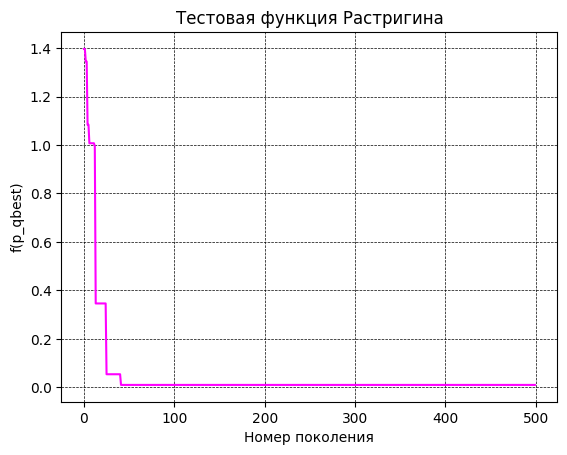

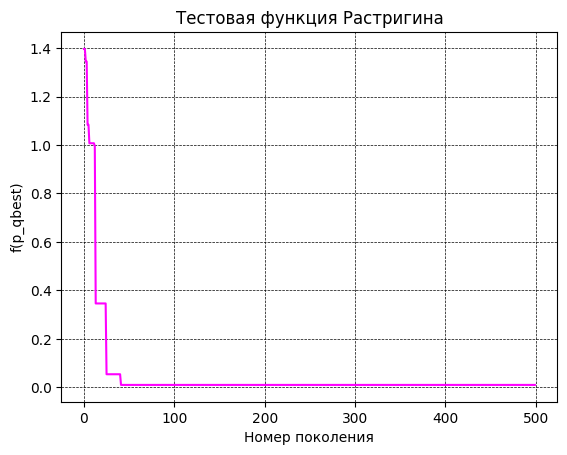

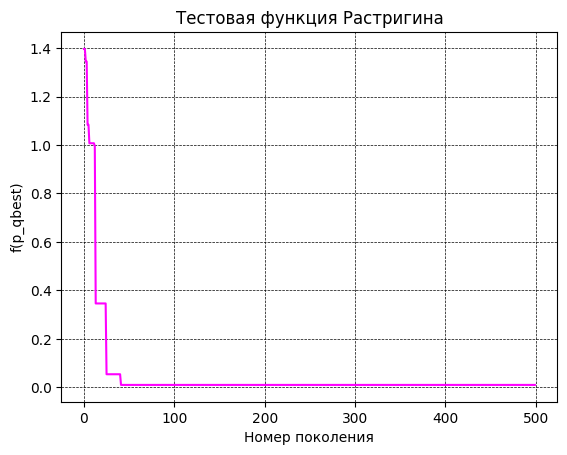

Test number: 1
Coordinates of p_qbest:			[-2.28467812e-05]
The function value of pqbest:		1.0355579149745608e-07
Algorithm running time:			0.02101755142211914 s


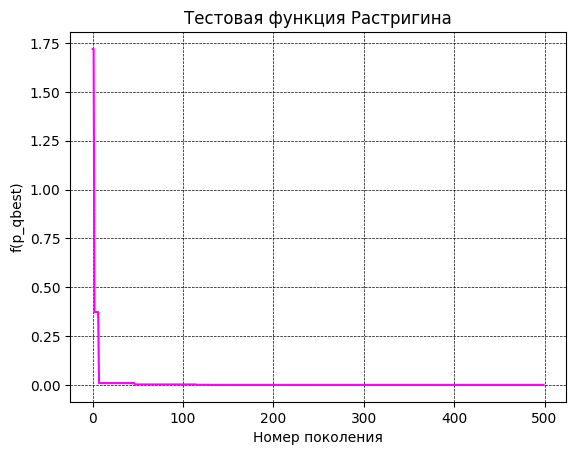

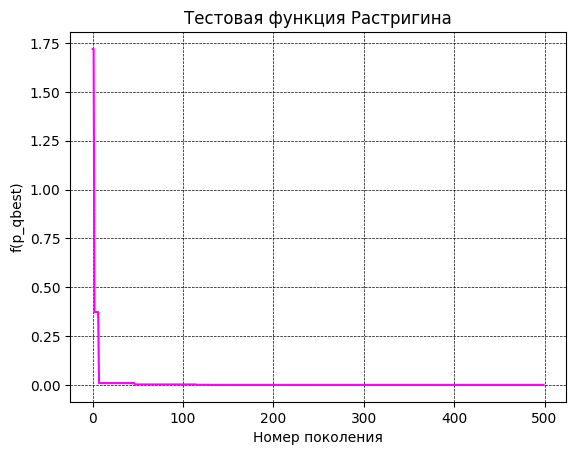

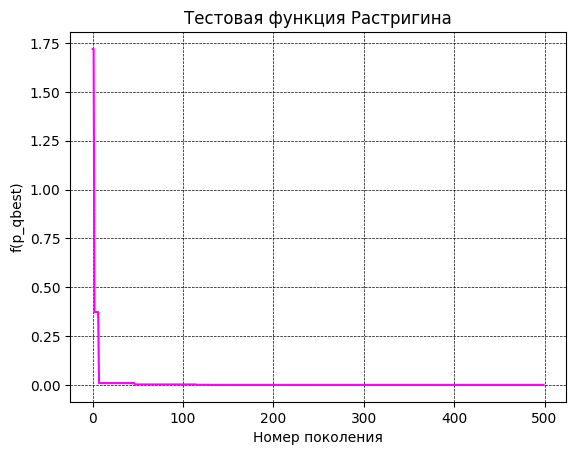

Test number: 2
Coordinates of p_qbest:			[3.06579319e-05]
The function value of pqbest:		1.864704675114126e-07
Algorithm running time:			0.022999048233032227 s


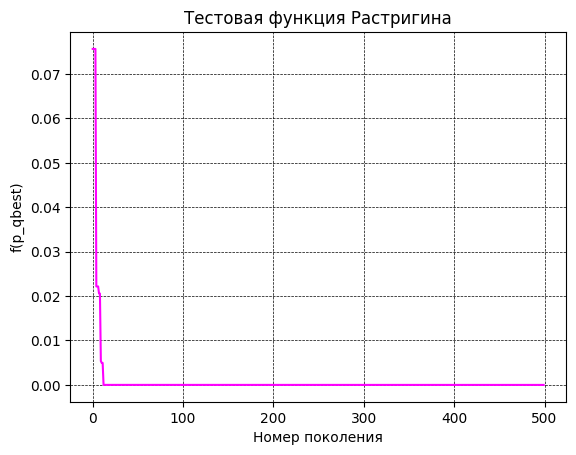

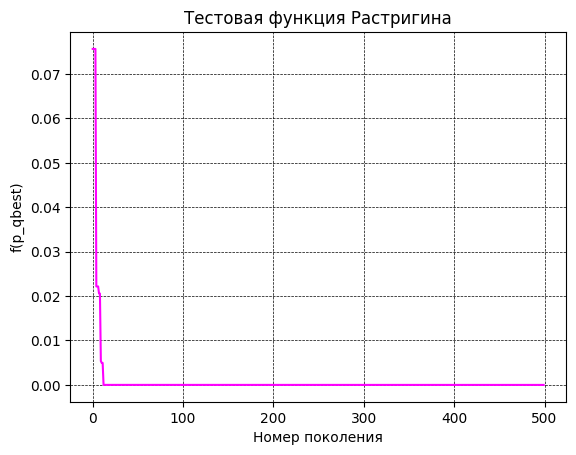

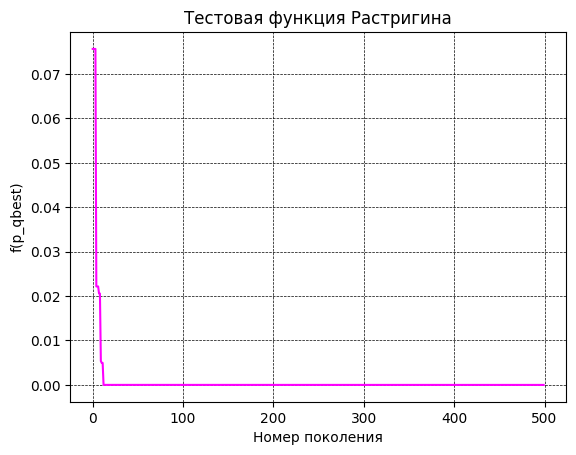

Test number: 3
Coordinates of p_qbest:			[-0.00012028]
The function value of pqbest:		2.8702713379402667e-06
Algorithm running time:			0.019992828369140625 s


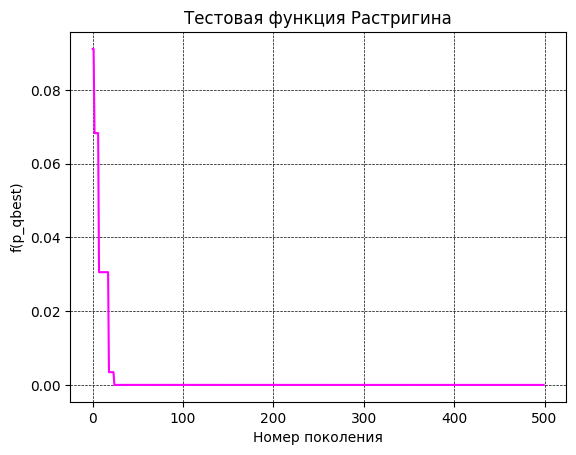

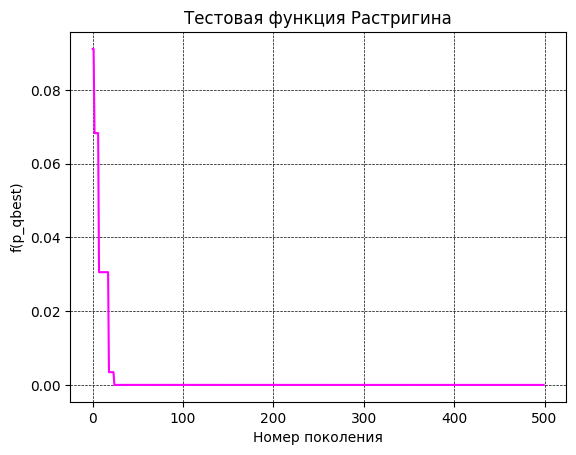

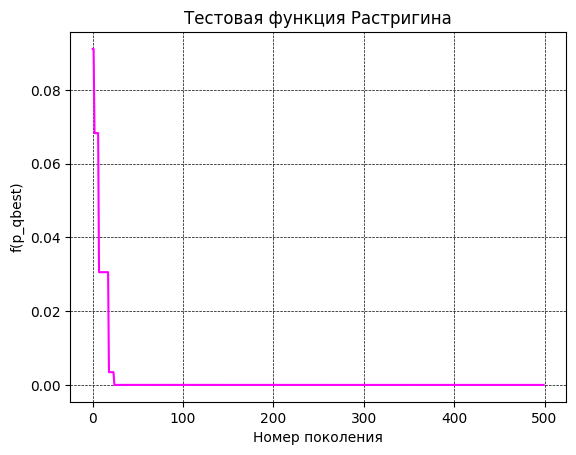

Test number: 4
Coordinates of p_qbest:			[-0.00135289]
The function value of pqbest:		0.00036311601498617563
Algorithm running time:			0.02500128746032715 s


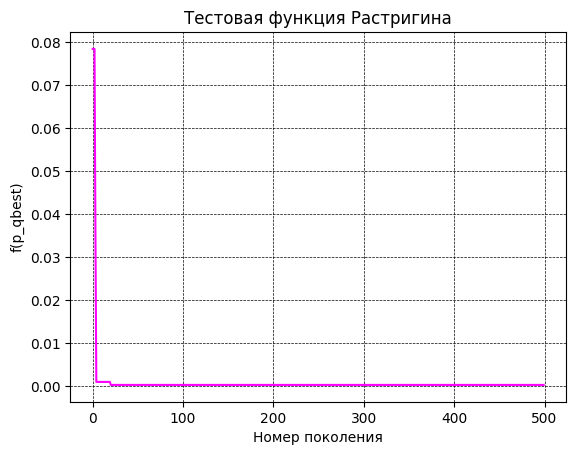

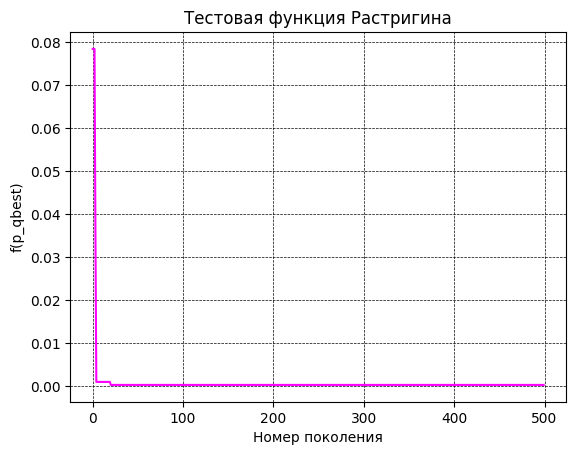

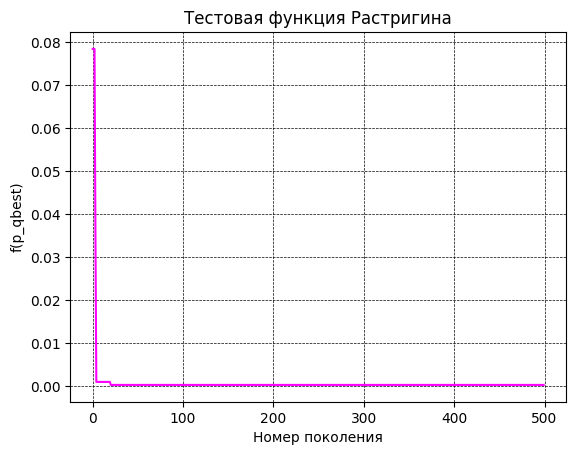

Test number: 5
Coordinates of p_qbest:			[0.00019149]
The function value of pqbest:		7.274982671390262e-06
Algorithm running time:			0.020992517471313477 s


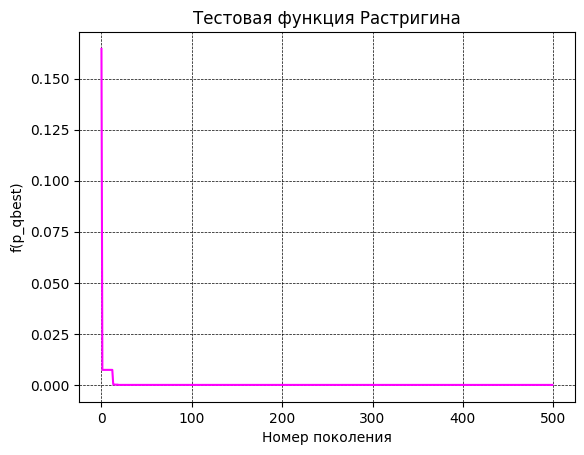

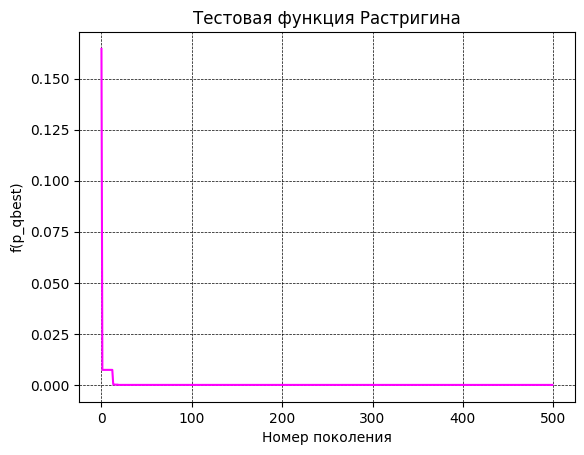

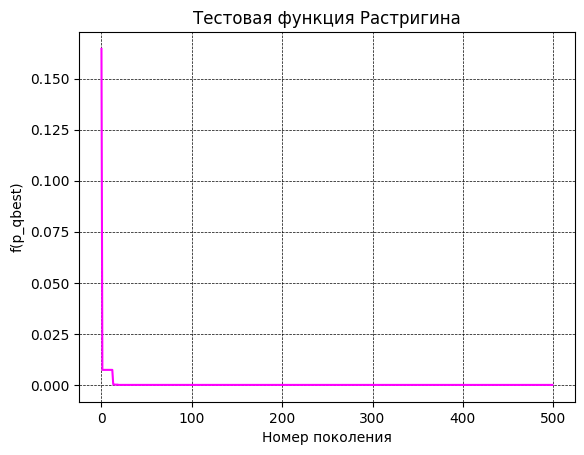

Test number: 6
Coordinates of p_qbest:			[0.00037347]
The function value of pqbest:		2.767219211996519e-05
Algorithm running time:			0.02101278305053711 s


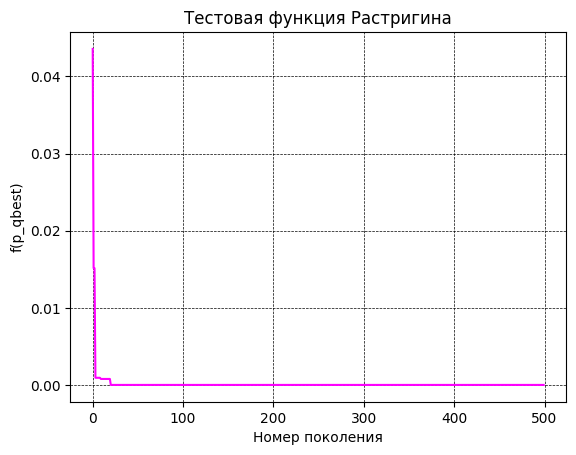

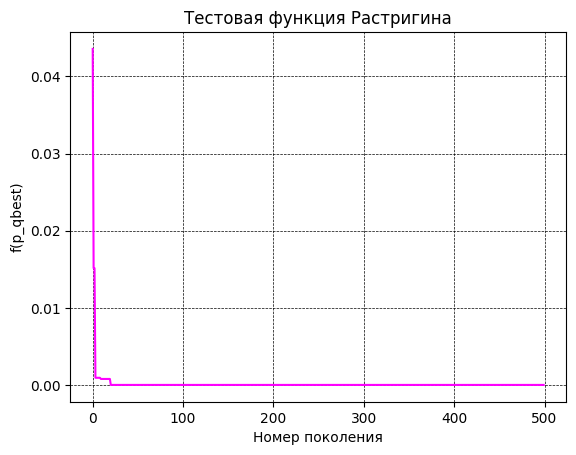

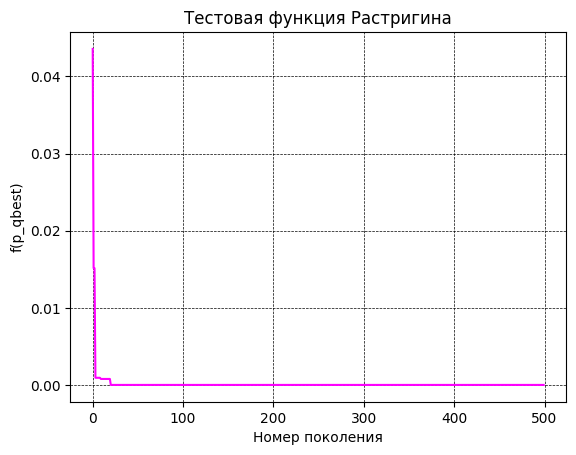

Test number: 7
Coordinates of p_qbest:			[0.0001049]
The function value of pqbest:		2.1833116221614546e-06
Algorithm running time:			0.02000260353088379 s


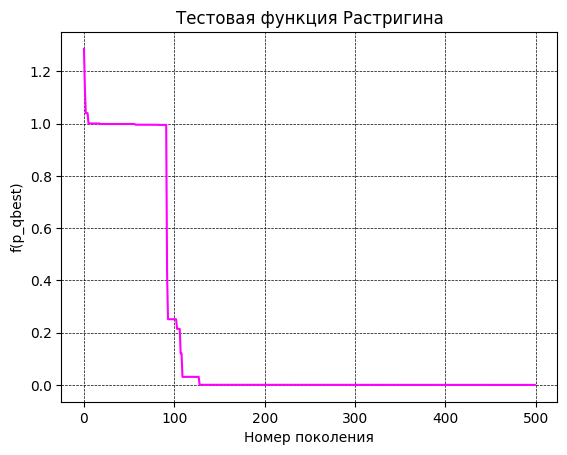

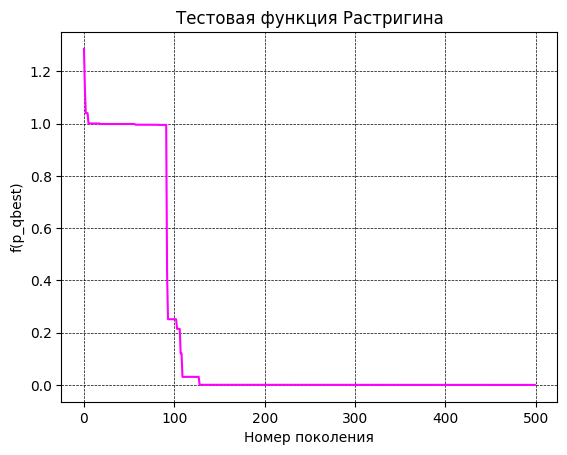

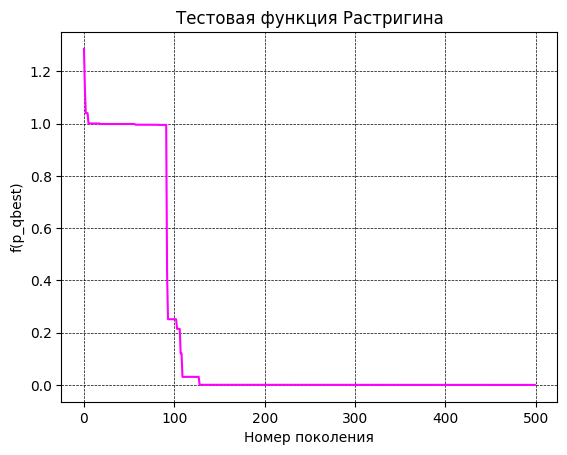

Test number: 8
Coordinates of p_qbest:			[-9.78938925e-05]
The function value of pqbest:		1.9012338121626726e-06
Algorithm running time:			0.02101588249206543 s


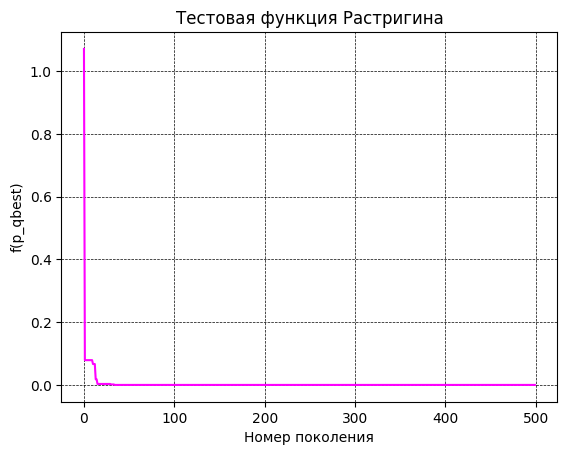

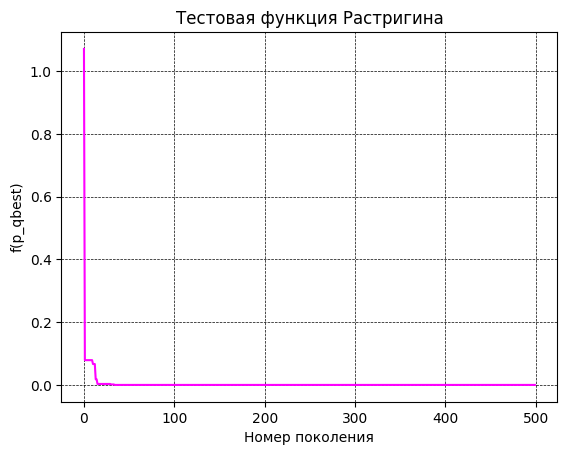

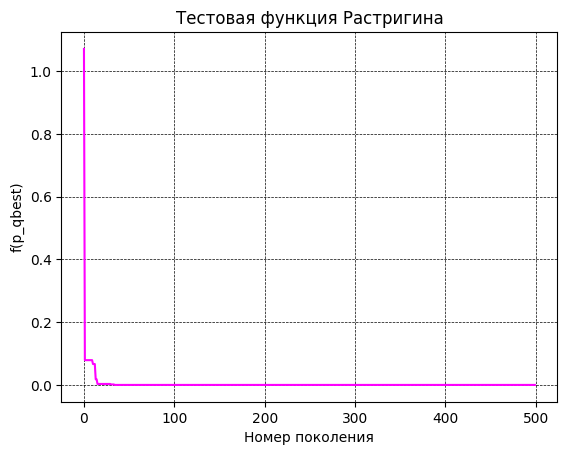

Test number: 9
Coordinates of p_qbest:			[4.45927071e-05]
The function value of pqbest:		3.9450455346923263e-07
Algorithm running time:			0.02100396156311035 s


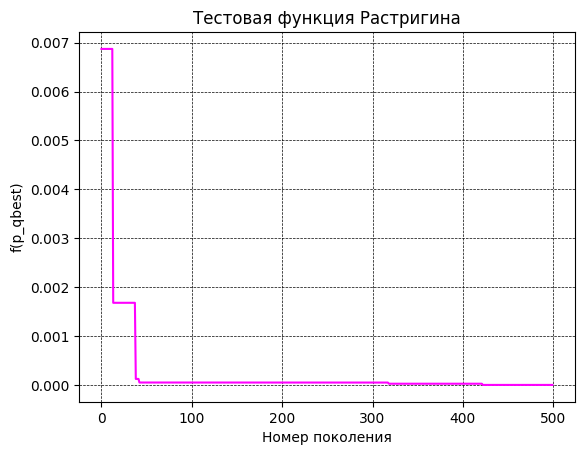

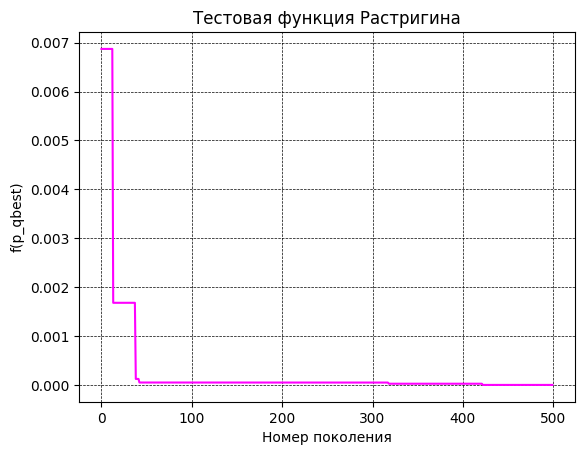

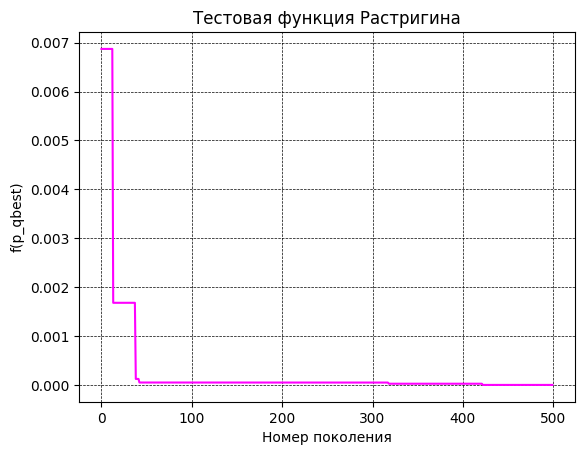

Test number: 0
Coordinates of p_qbest:			[-1.0258576e-05]
The function value of pqbest:		2.0878463402596026e-08
Algorithm running time:			3.0673141479492188 s


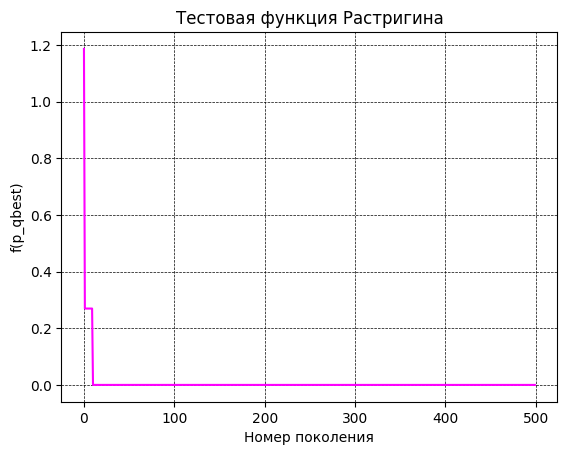

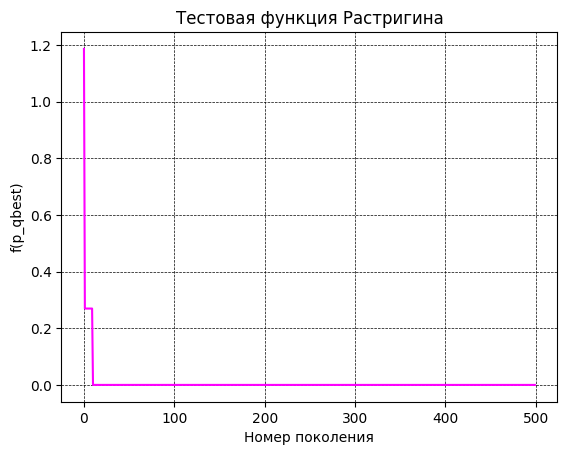

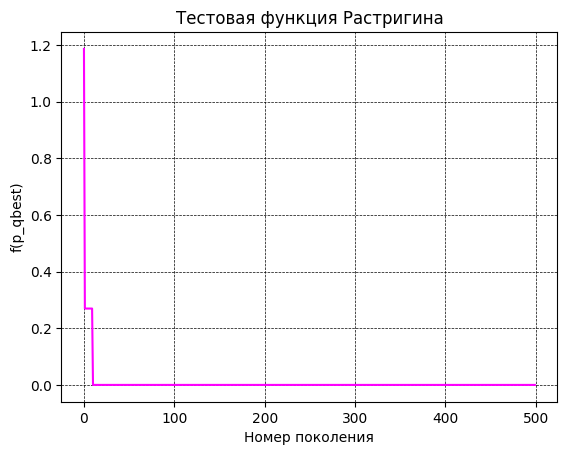

Test number: 1
Coordinates of p_qbest:			[0.00026538]
The function value of pqbest:		1.3971870167495126e-05
Algorithm running time:			0.024006366729736328 s


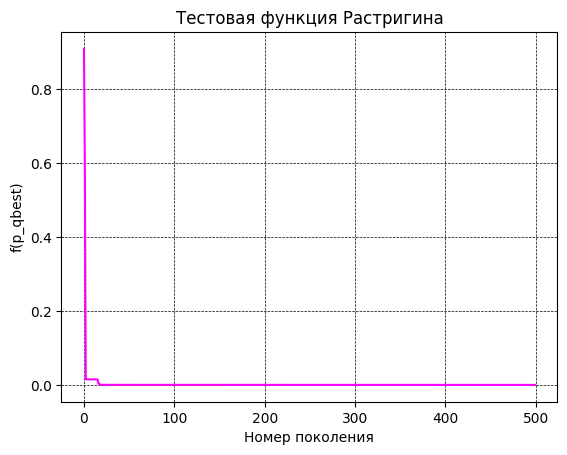

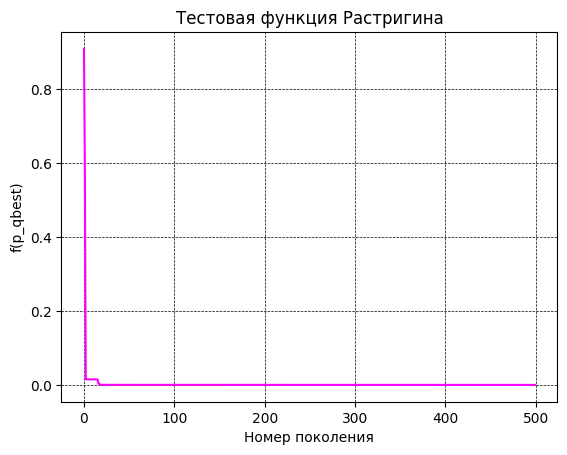

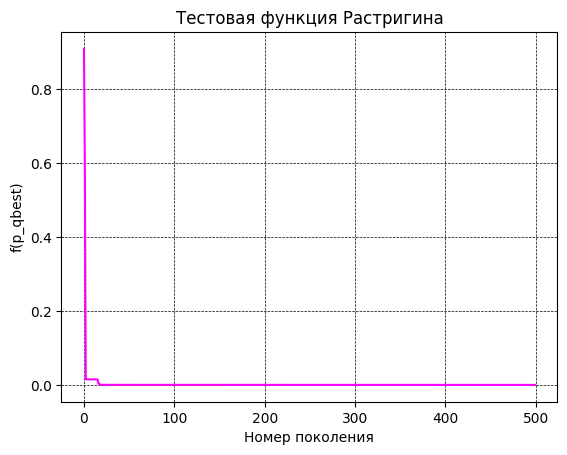

Test number: 2
Coordinates of p_qbest:			[0.00162225]
The function value of pqbest:		0.00052210183589807
Algorithm running time:			0.020004987716674805 s


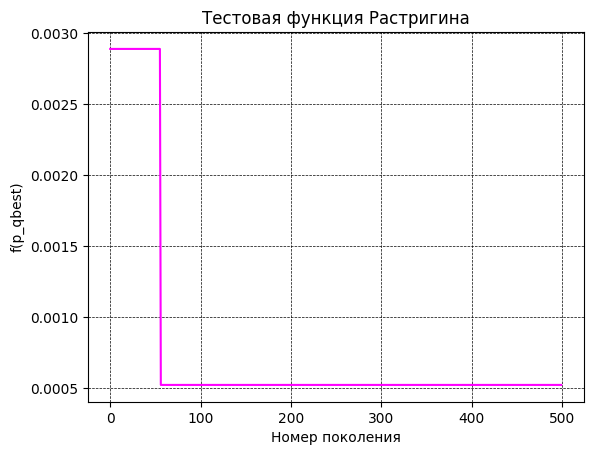

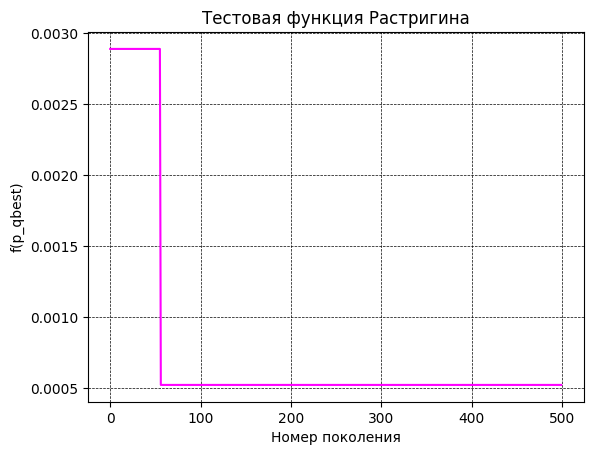

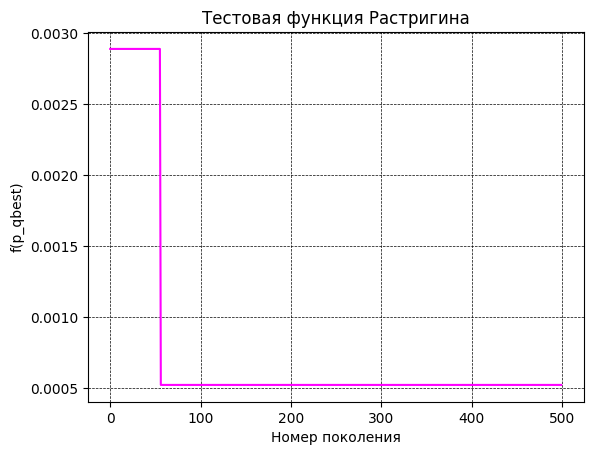

Test number: 3
Coordinates of p_qbest:			[0.01175054]
The function value of pqbest:		0.02738064825783937
Algorithm running time:			0.02001953125 s


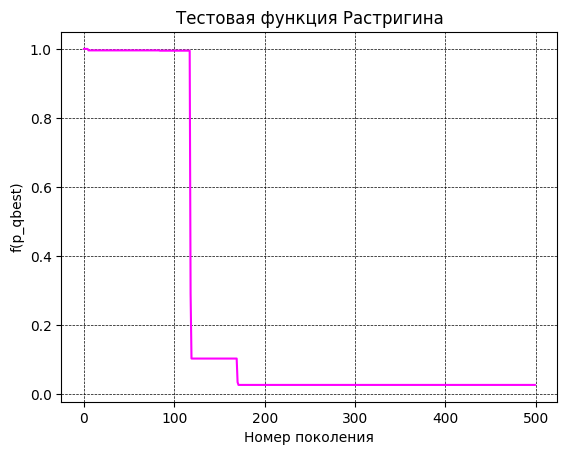

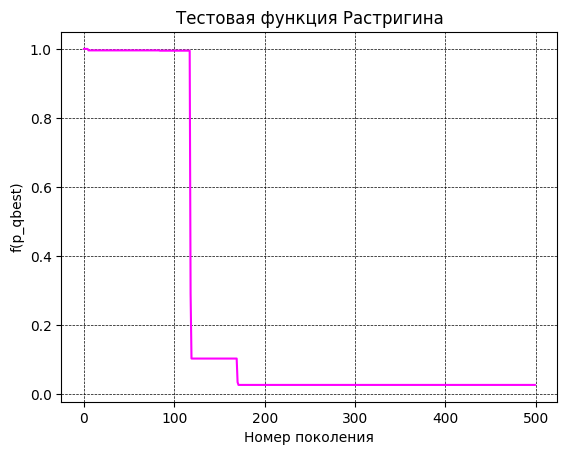

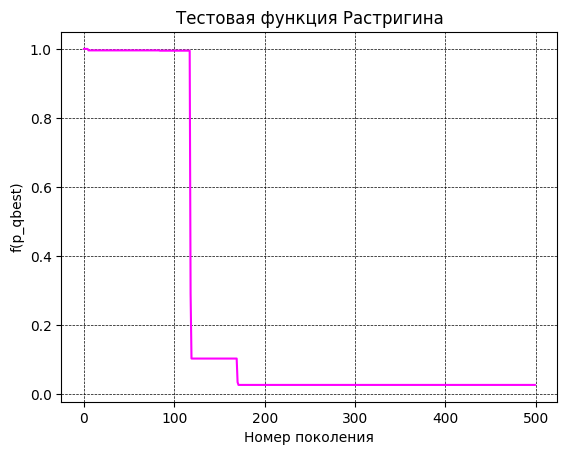

Test number: 4
Coordinates of p_qbest:			[0.00058001]
The function value of pqbest:		6.674061621048111e-05
Algorithm running time:			0.024005889892578125 s


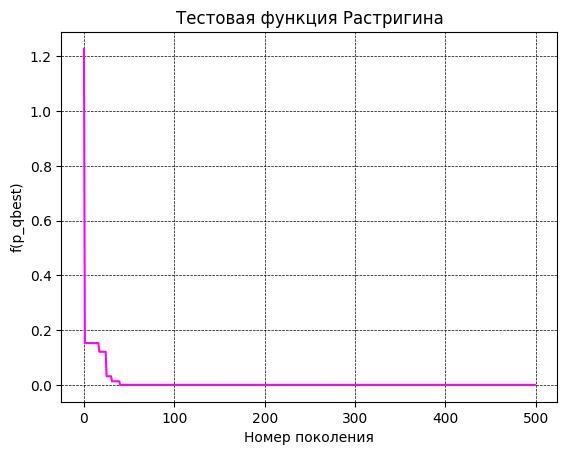

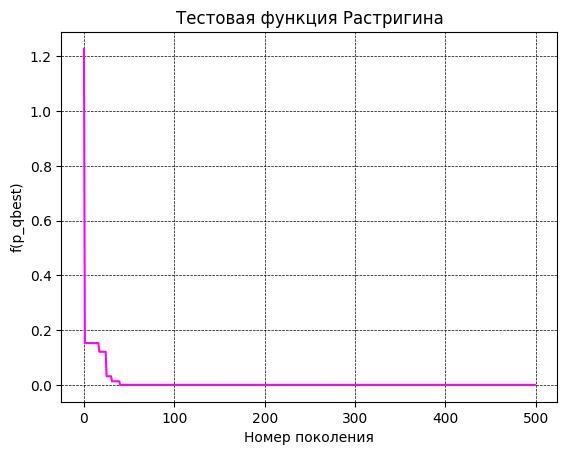

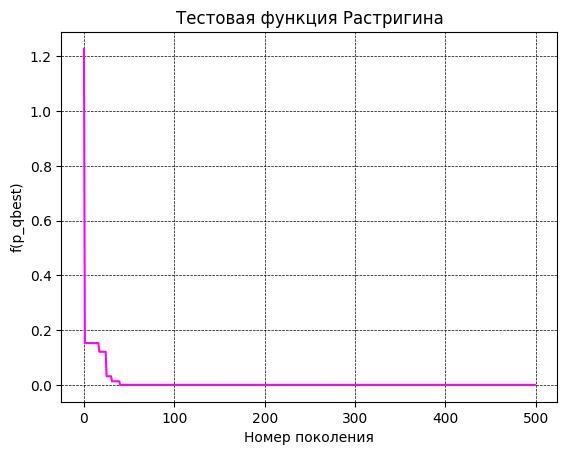

Test number: 5
Coordinates of p_qbest:			[7.87463579e-08]
The function value of pqbest:		1.2292389328649733e-12
Algorithm running time:			0.021011829376220703 s


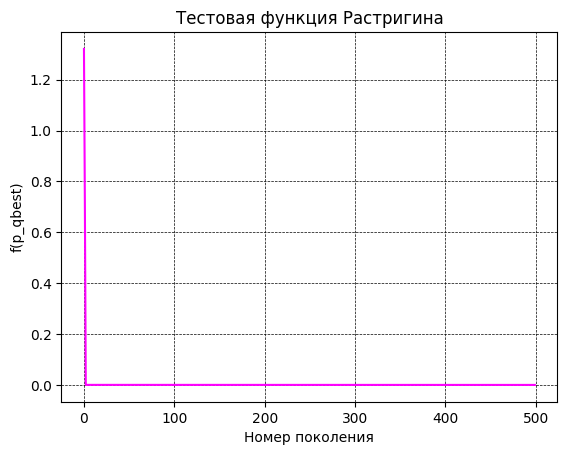

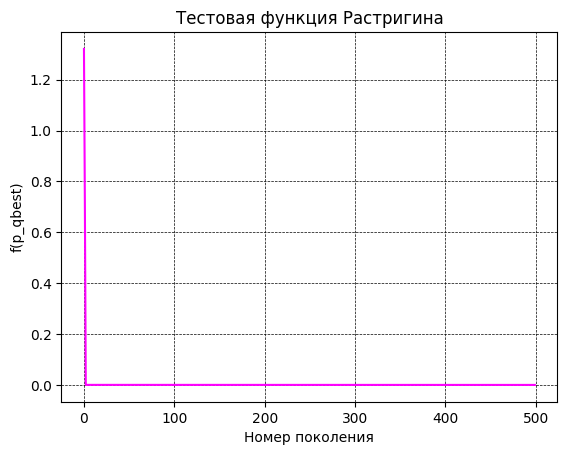

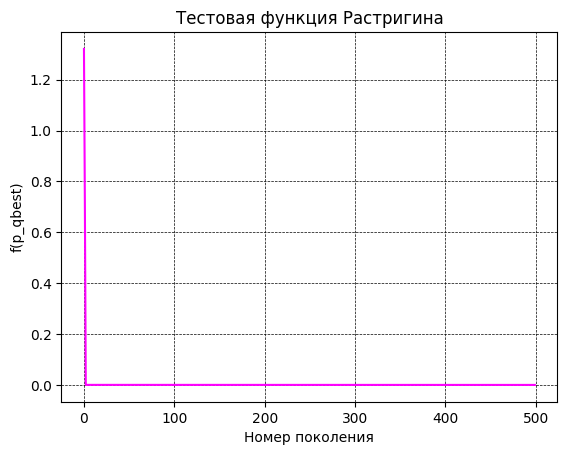

Test number: 6
Coordinates of p_qbest:			[-0.00027063]
The function value of pqbest:		1.4530182998129249e-05
Algorithm running time:			0.020998477935791016 s


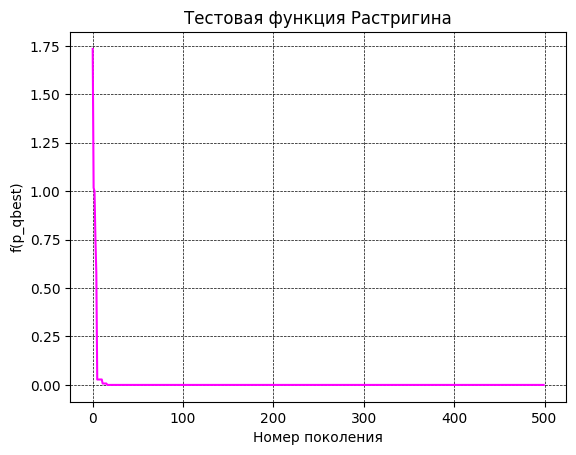

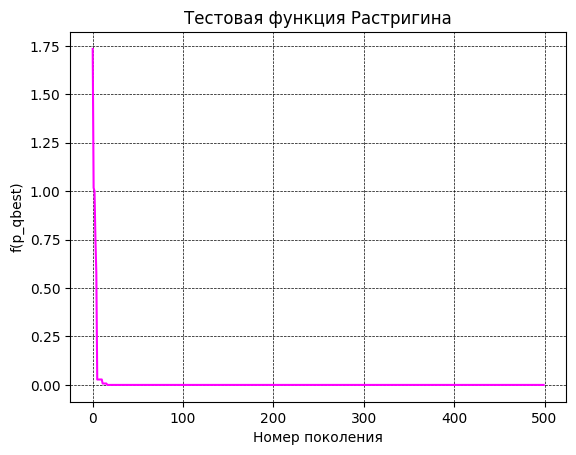

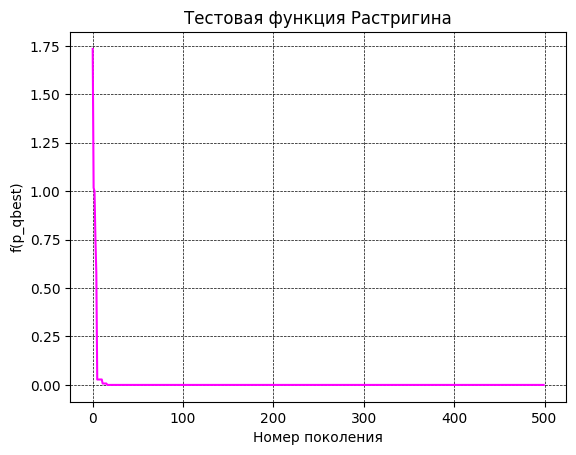

Test number: 7
Coordinates of p_qbest:			[8.03442131e-05]
The function value of pqbest:		1.280659105873383e-06
Algorithm running time:			0.022005796432495117 s


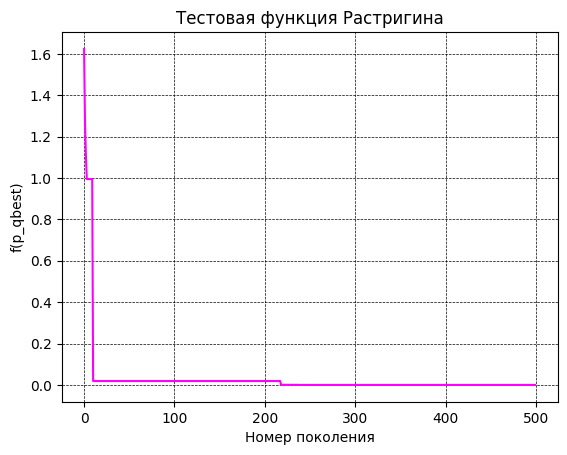

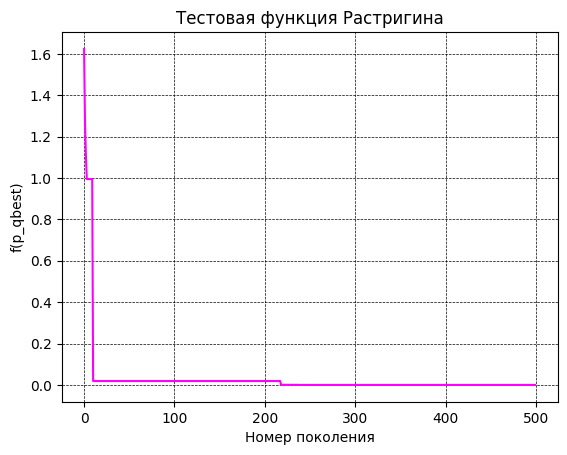

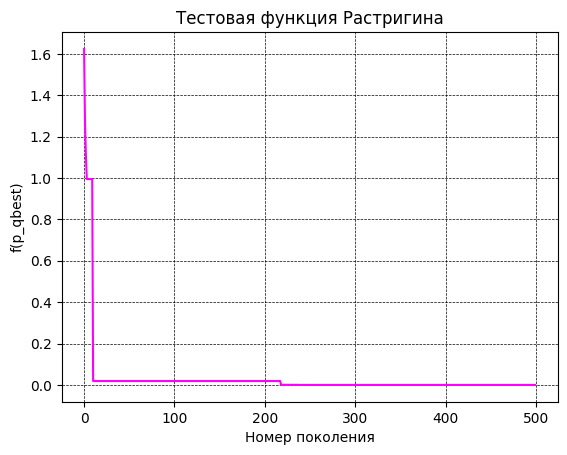

Test number: 8
Coordinates of p_qbest:			[-0.00019207]
The function value of pqbest:		7.318590144578252e-06
Algorithm running time:			0.021007537841796875 s


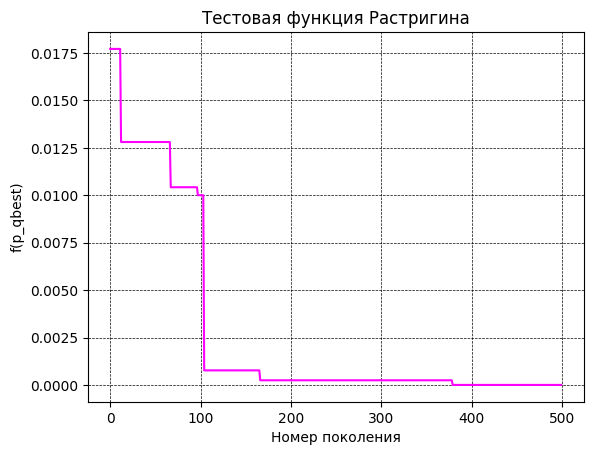

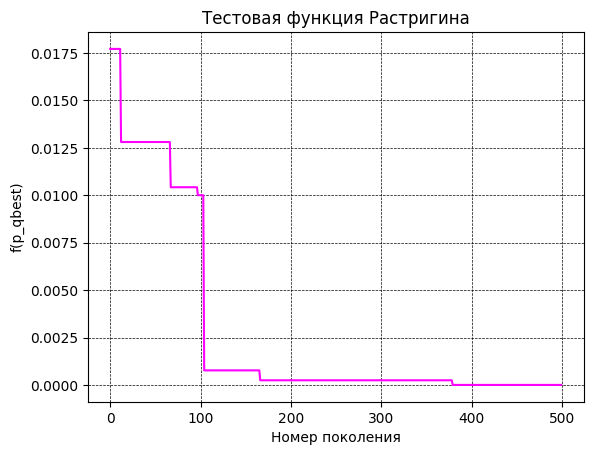

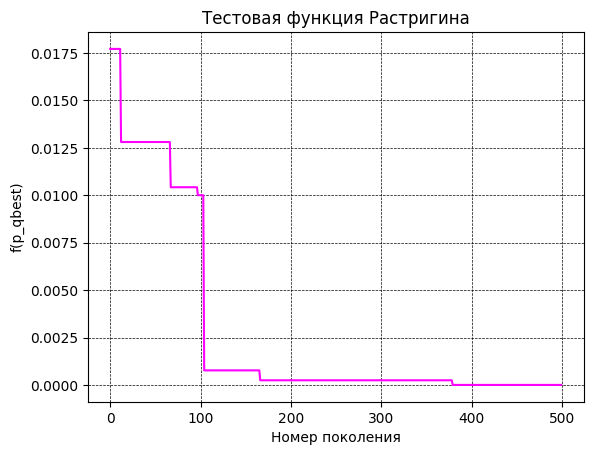

Test number: 9
Coordinates of p_qbest:			[0.00197959]
The function value of pqbest:		0.0007774481230740093
Algorithm running time:			0.02301502227783203 s


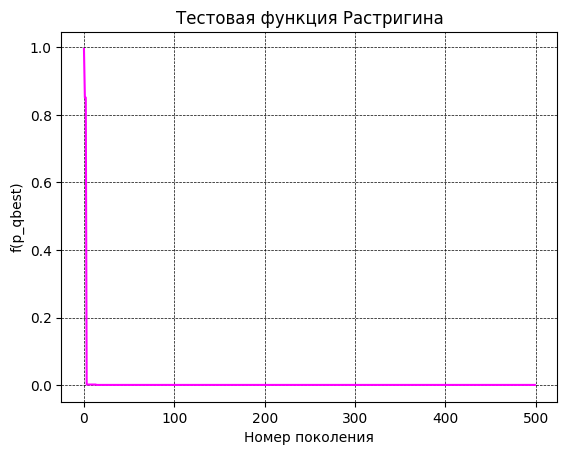

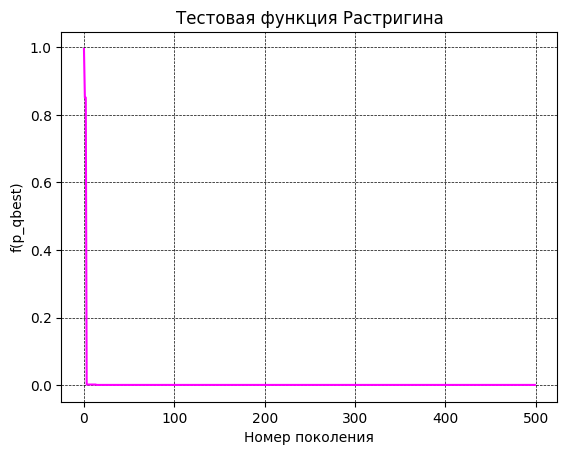

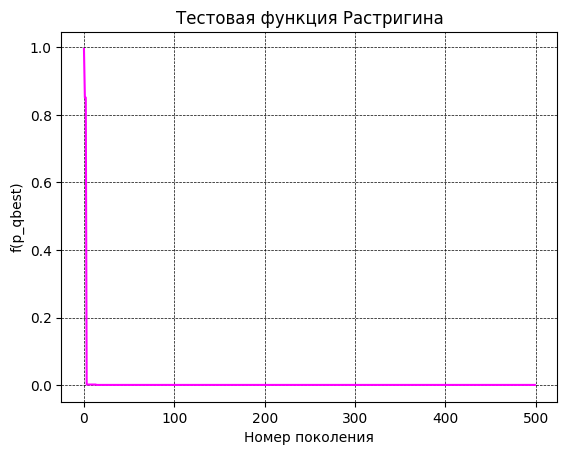

In [181]:
start_test()